# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
# import tensorflow as tf
# from tensorflow.keras import layers, regularizers, callbacks
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings 
warnings.filterwarnings("ignore")

In [17]:
global_seed = 860418863
loaded_df = pd.read_csv("../Output/Data/processed_data.csv")
loaded_df.head(1)
loaded_df['Price'] = loaded_df['Price'] / 644823451 #/ 25500 # chuyển sang đô la
loaded_df = loaded_df.drop(columns=['CPU Name','GPU Name','Storage Type'])
loaded_df = loaded_df.sample(frac=1,random_state=global_seed).reset_index(drop=True)
split_index = int(len(loaded_df)*0.85)
train_val_df = loaded_df.iloc[:split_index]
test_df = loaded_df.iloc[split_index:]
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

## Info

In [92]:
loaded_df.describe()

,Price,CPU Lithography,CPU Core,CPU Thread,CPU Cache,CPU Base Clock,CPU Max Clock,CPU Intel,CPU Series,RAM,...,GPU Onboard,GPU AMD,GPU NVIDIA,Display Type,Display Size,Display Frequency,OS,Warrant,Display Width,Display Height
count,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,...,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,32.749062,7.149007,11.780353,16.207506,18.252759,3.642605,4.791336,0.952539,6.178808,25.090508,...,0.768212,0.040839,0.190949,0.694260,15.232009,93.509934,10.823400,19.889625,2164.852097,1287.456954
std,23.390985,1.083724,4.724602,6.462214,8.581434,1.565038,0.339824,0.212741,1.602840,20.742317,...,0.422207,0.198026,0.393266,0.460974,2.154515,54.931182,0.381541,8.305557,434.109967,305.769358
min,8.490000,4.000000,2.000000,4.000000,6.000000,0.700000,3.700000,0.000000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,30.000000,10.000000,12.000000,1920.000000,1080.000000
25%,18.615000,7.000000,10.000000,12.000000,12.000000,1.800000,4.600000,1.000000,5.000000,16.000000,...,1.000000,0.000000,0.000000,0.000000,14.000000,60.000000,11.000000,12.000000,1920.000000,1080.000000
50%,24.094500,7.000000,10.000000,15.000000,12.000000,4.500000,4.700000,1.000000,7.000000,16.000000,...,1.000000,0.000000,0.000000,1.000000,15.000000,60.000000,11.000000,24.000000,1920.000000,1080.000000
75%,37.990000,7.000000,14.000000,20.000000,24.000000,4.700000,5.000000,1.000000,7.000000,32.000000,...,1.000000,0.000000,0.000000,1.000000,16.000000,120.000000,11.000000,24.000000,2560.000000,1440.000000
max,149.990000,14.000000,24.000000,32.000000,80.000000,5.600000,5.800000,1.000000,9.000000,128.000000,...,1.000000,1.000000,1.000000,1.000000,32.000000,360.000000,11.000000,36.000000,4500.000000,3000.000000


In [19]:
def get_description(df_ : pd.DataFrame,name : str = 'Default',col : str = 'Price'):
    result = {
        'Name' : name,
        'Max' : df_[col].max(),
        'Min' : df_[col].min(),
        'Mean' : df_[col].mean(),
        'Var' : df_[col].var(),
        'Std' : df_[col].std()
    }
    return result
def print_table(dicts : list[dict[str,float]]):
    print()
    row = ''
    for key in dicts[0].keys():
        row += f'{key:20}'
    print(row)
    for dict_ in dicts:
        row = ''
        for key in dict_:
            row += f'{dict_[key]:20}'
        print(row)
train_val_dict = get_description(train_val_df,'TrainVal')
test_dict = get_description(test_df,'Test')
total_dict = get_description(loaded_df,'All')
print_table([train_val_dict,test_dict,total_dict])
def calculate_diff_percent(num1, num2):
    # return max(abs(num1-num2)/num1,abs(num1-num2)/num2)
    return abs(num1-num2)/num2
if (
    calculate_diff_percent(train_val_dict['Var'],total_dict['Var']) > 0.1 or
    calculate_diff_percent(test_dict['Var'],total_dict['Var']) > 0.1 or
    calculate_diff_percent(train_val_dict['Mean'],total_dict['Mean']) > 0.05 or
    calculate_diff_percent(test_dict['Mean'],total_dict['Mean']) > 0.05 or
    calculate_diff_percent(train_val_dict['Std'],total_dict['Std']) > 0.05 or
    calculate_diff_percent(test_dict['Std'],total_dict['Std']) > 0.05
):
    print('Unbalanced')
    import random
    global_seed = random.randint(0,1000000000)
    loaded_df = pd.read_csv("../Output/Data/processed_data.csv")
    loaded_df.head(1)
    loaded_df['Price'] = loaded_df['Price'] / 1000000 #/ 25500 # chuyển sang đô la
    loaded_df = loaded_df.drop(columns=['CPU Name','GPU Name','Storage Type'])
    loaded_df = loaded_df.sample(frac=1,random_state=global_seed).reset_index(drop=True)
    split_index = int(len(loaded_df)*0.85)
    train_val_df = loaded_df.iloc[:split_index]
    test_df = loaded_df.iloc[split_index:]
    X_test = test_df.drop('Price', axis=1)
    y_test = test_df['Price']
else:
    print('Balaned')
    print('Seed : {}'.format(global_seed))
    


Name                Max                 Min                 Mean                Var                 Std                 
TrainVal                          149.99                8.79  32.858789610389614   545.2665270792157  23.350942744977466
Test                              149.99                8.49  32.127808823529406   561.3950572965142  23.693776763034514
All                               149.99                8.49   32.74906181015453   547.1381800249045  23.390985016131847
Balaned
Seed : 860418863


## Correlation Matrix

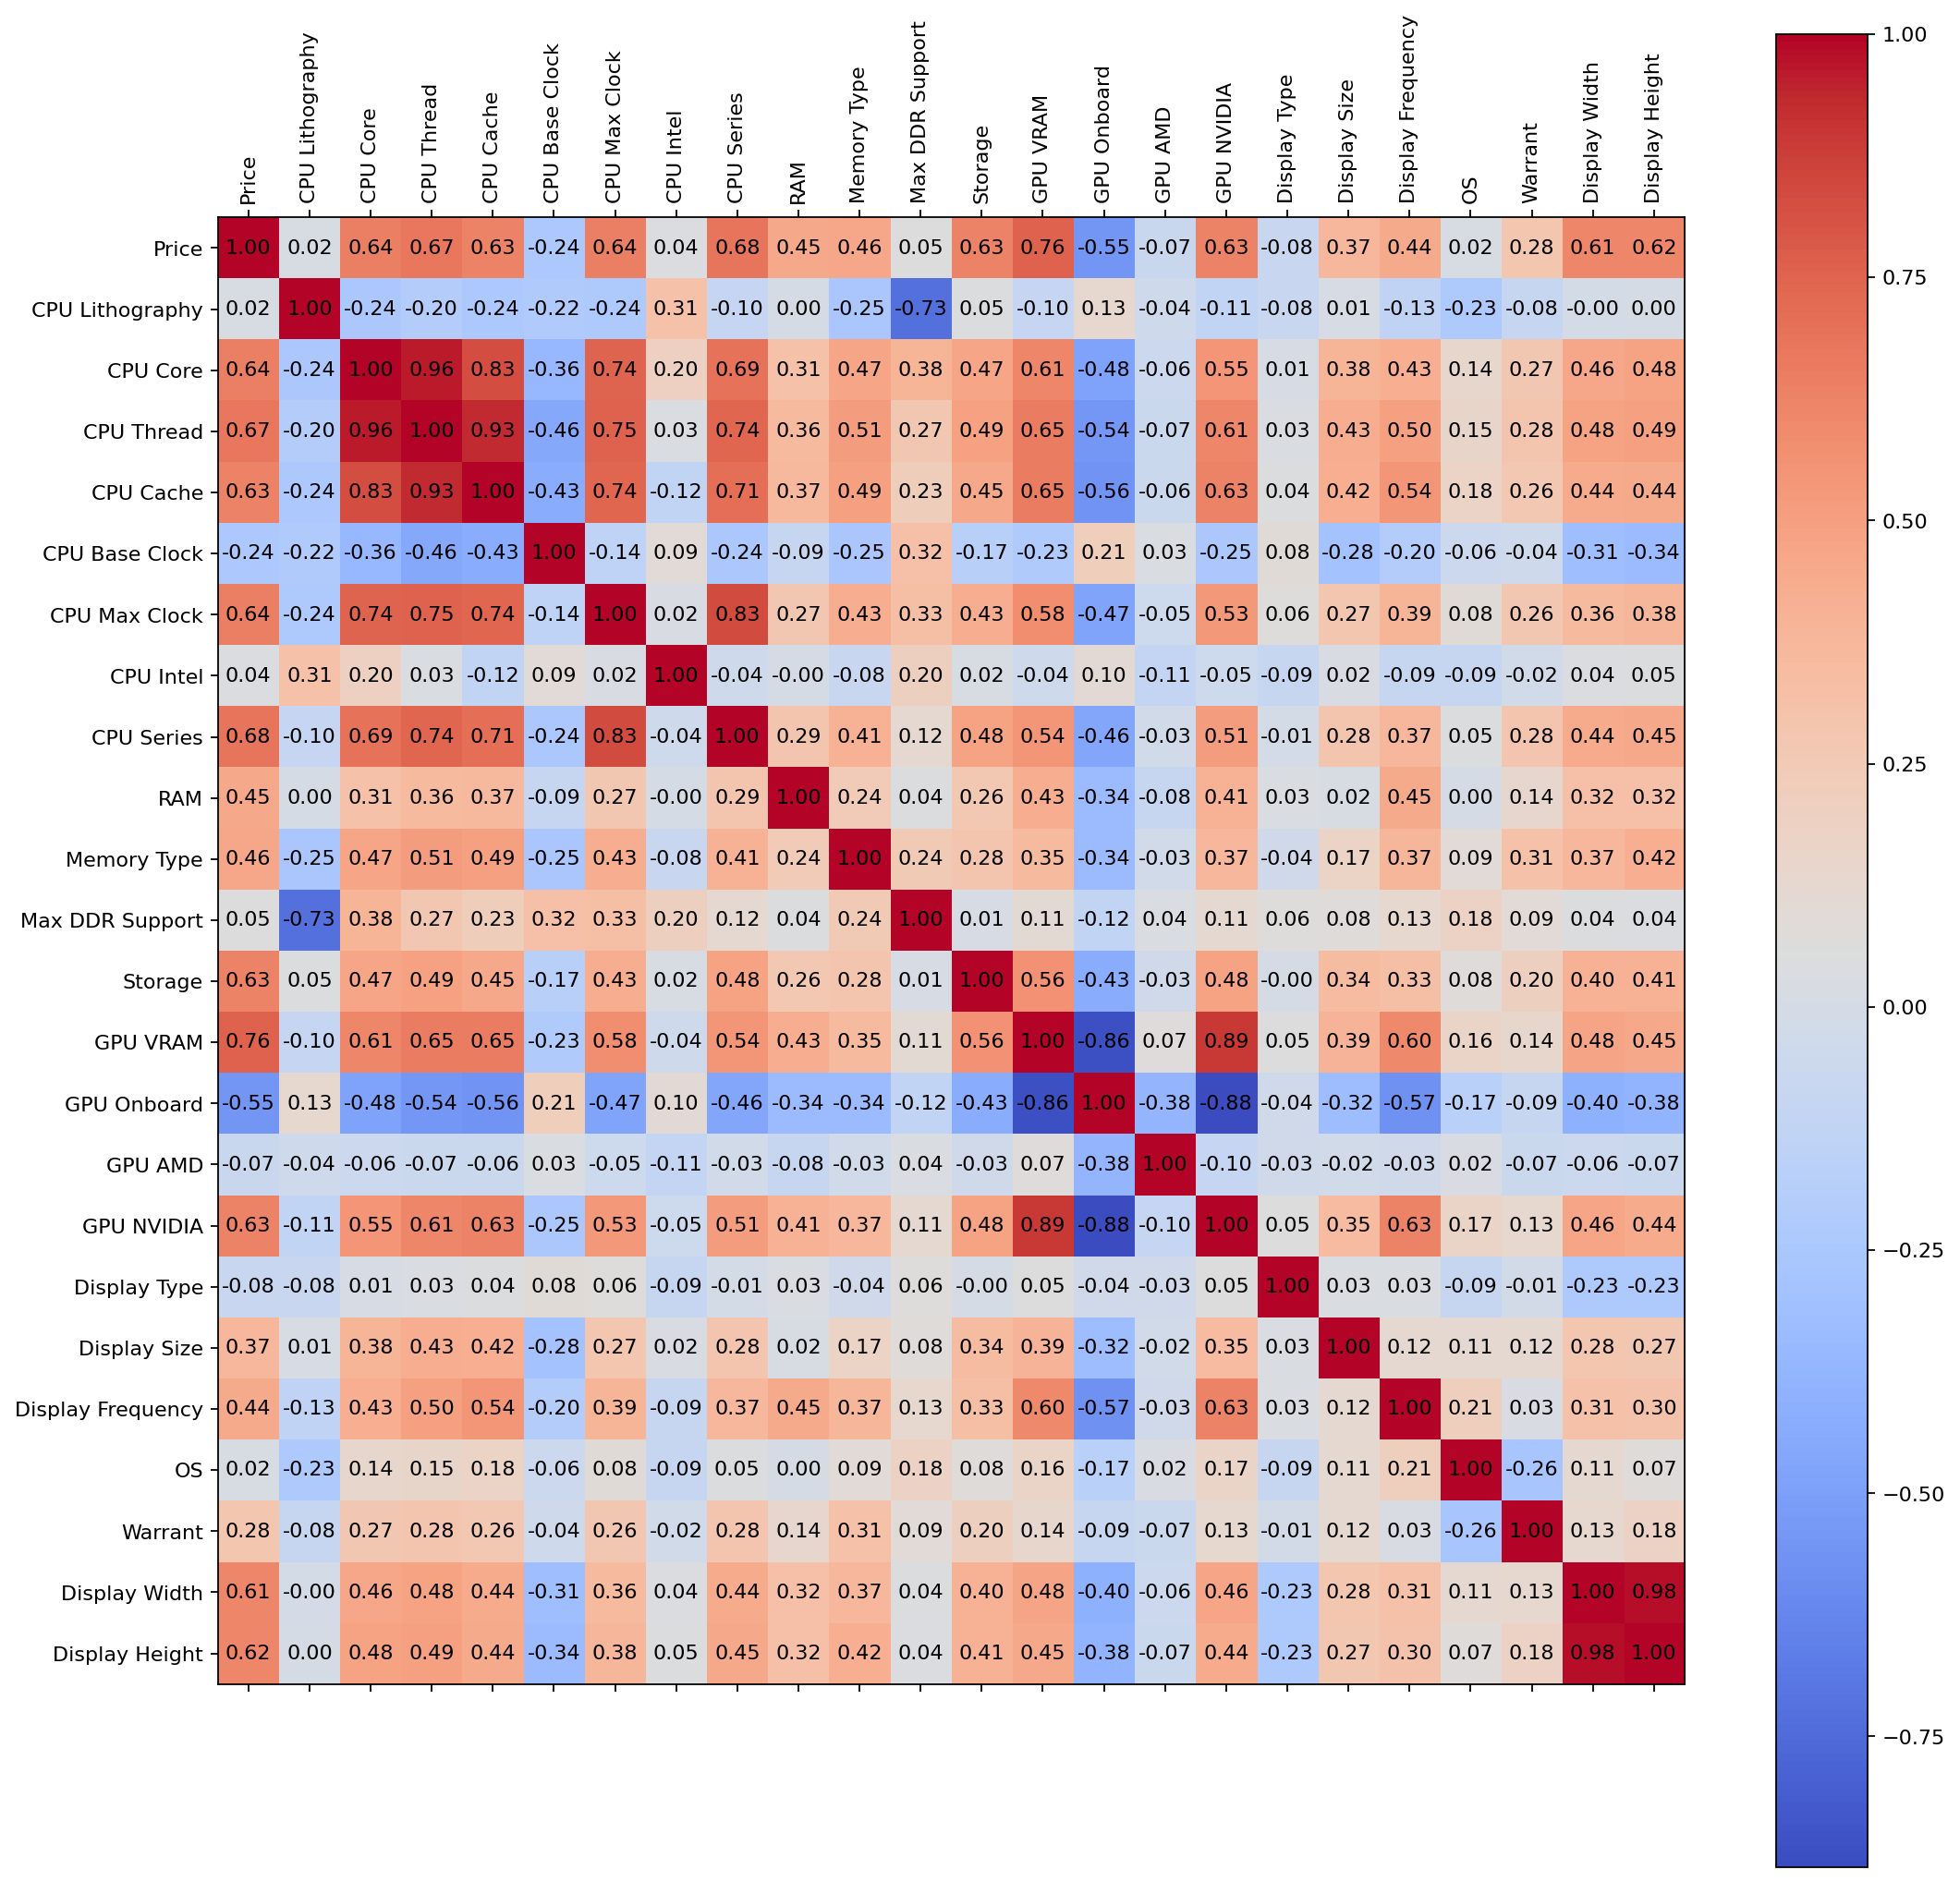

In [86]:
correlation_matrix = loaded_df.corr()
plt.figure(figsize=(16,16),dpi=160)
plt.matshow(correlation_matrix,cmap='coolwarm',fignum=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)),correlation_matrix.columns,rotation=90)
plt.yticks(range(len(correlation_matrix.columns)),correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j,i,f'{correlation_matrix.iloc[j,i]:.2f}',ha='center',va='center',color='black')
    #break
plt.savefig('..\Output\Image\Correlation.png',dpi=320)
plt.show()


# Mean Predict

In [35]:
mean_pred = train_val_df.mean()
mean_df = pd.DataFrame([mean_pred]*len(y_test))
mean_y = mean_df['Price']
mean_X = mean_df.drop('Price', axis=1)
mean_r2 = r2_score(y_true=y_test,y_pred=mean_y)
mean_mse = mean_squared_error(y_test,mean_y)
mean_mae = mean_absolute_error(y_test,mean_y)
print('Mean R2 : {}'.format(mean_r2))
print('Mean MSE : {}'.format(mean_mse))
print('Mean MAE : {}'.format(mean_mae))

Mean R2 : -0.0009588451578326218
Mean MSE : 557.8014853742103
Mean MAE : 16.922966004583653


# Simple Linear Regression

In [38]:
df = train_val_df.copy()
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=global_seed)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

r2 = r2_score(y_test,y_pred)
print(f'R2 Score: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

Mean squared error: 106.64801618312943
R2 Score: 0.8086231788260229
Mean absolute error: 7.397953642665923


# Polynomial Regression

Reset Dataframe to default

In [37]:
df = train_val_df.copy()
test_df = loaded_df[split_index:]
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

Polynomial Modify

In [33]:
degree = 2
cols = loaded_df.columns
cols = list(cols)
cols.remove('Price')
# cols = [
#     'GPU VRAM'
# ]
test_df = loaded_df[split_index:]
df = train_val_df.copy()
for col in cols:
    test_df[col + ' P'] = test_df[col] ** degree
    df[col + ' P'] = df[col] ** degree
    
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

In [34]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=global_seed)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

r2 = r2_score(y_test,y_pred)
print(f'R2 Score: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

Mean squared error: 92.7968042087135
R2 Score: 0.833478783383344
Mean absolute error: 6.7826632112704335


## Grid Search

In [85]:
def grid_search_polynomial(pow : float = 2,cross_val : bool = True,random_state : int = global_seed):
    cols = train_val_df.columns
    result = {}
    def inner_grid_search(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=random_state)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val,y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        inner_result = [r2,mae,mse]
        return inner_result
    def inner_grid_search_cross_val(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        model = LinearRegression()
        mse = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_squared_error').mean()
        r2 = cross_val_score(model,X_,y_,cv=5,scoring='r2').mean()
        mae = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_absolute_error').mean()
        inner_result = [r2,mae,mse]
        return inner_result
    for col in cols:
        df = train_val_df.copy()
        df[col+' S'] = df[col] ** pow
        if (cross_val == True):
            result[col] = inner_grid_search_cross_val(df)
        else:
            result[col] = inner_grid_search(df)
    if (cross_val == True):
        result['Base'] = inner_grid_search(train_val_df.copy())
    else:
        result['Base'] = inner_grid_search(train_val_df.copy())
    return result
def grid_search_product(cross_val : bool = True,random_state : int = global_seed):
    cols = train_val_df.columns
    result = {}
    def inner_grid_search(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=random_state)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val,y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        inner_result = [r2,mae,mse]
        return inner_result
    def inner_grid_search_cross_val(df_):
        X_ = df_.drop('Price', axis=1)
        y_ = df_['Price']
        model = LinearRegression()
        mse = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_squared_error').mean()
        r2 = cross_val_score(model,X_,y_,cv=5,scoring='r2').mean()
        mae = -cross_val_score(model,X_,y_,cv=5,scoring='neg_mean_absolute_error').mean()
        inner_result = [r2,mae,mse]
        return inner_result
    for i in range(len(cols)):
        for j in range(i+1,len(cols)):
            df = train_val_df.copy()
            df['Product Column'] = df[cols[i]] * df[cols[j]]
            if (cross_val == True):
                result[cols[i] + '|' + cols[j]] = inner_grid_search_cross_val(df)
            else:
                result[cols[i] + '|' + cols[j]] = inner_grid_search(df)
    if (cross_val == True):
        result['Base'] = inner_grid_search_cross_val(train_val_df.copy())
    else:
        result['Base'] = inner_grid_search(train_val_df.copy())
    return result
def format_result(result_ : dict):
    base = result_['Base']
    for key in result_:
        if (key != 'Base'):
            for i in range(len(result_[key])):
                result_[key][i] -= base[i]
def sorted_print(result_ : dict):
    local_result = result_.copy()
    while(len(local_result) > 0):
        max = -1
        max_key = None
        for key in local_result:
            if (local_result[key][0] > max):
                max = local_result[key][0]
                max_key = key
        print(local_result[max_key],max_key)
        local_result.pop(max_key)


In [87]:
df = train_val_df.copy()
test_df = loaded_df[split_index:]
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

result = grid_search_product()
format_result(result)
sorted_print(result)
# for col in result:
#     print(result[col],col)

[0.7718371007417145, 7.478927167700094, 123.61063926919493] Base
[0.2273287801417565, -7.110448703056394, -123.16022539108661] Price|OS
[0.22617443853875074, -7.011695865849019, -122.39321929414001] Price|Max DDR Support
[0.22505289069688783, -6.700580227951952, -121.8600510807269] Price|Memory Type
[0.22470767639275313, -6.606898003545235, -121.5579354446875] Price|CPU Max Clock
[0.2114966168758523, -5.3106293730310785, -114.90986114824202] Price|CPU Series
[0.19838062797649503, -6.011102084334941, -111.65695134179992] Price|CPU Intel
[0.19391663105251966, -5.398541284911332, -103.1471539283599] Price|CPU Lithography
[0.1938455574006932, -5.157407487339739, -104.12604799773246] Price|Display Size
[0.1866988239155314, -4.435375879976035, -100.39814536951415] Price|Display Width
[0.1816668544975727, -4.319571250483074, -97.47120764892733] Price|Display Height
[0.17900539390932946, -3.959364468185383, -95.9855514557753] Price|CPU Thread
[0.1706131453414006, -3.9391623178483517, -93.00475

# Other

In [45]:
def grid_search_single_poly(from_ : float,to_ : float, step : float):
    result = []
    def inner(value):
        df = train_val_df.copy()

        df['GPU VRAM S'] = df['GPU VRAM']**0.25
        df['Warrant S'] = df['Warrant']**0.975

        # test_df = loaded_df[split_index:]
        # test_df['GPU VRAM S'] = test_df['GPU VRAM']**value
        # test_df['Warrant S'] = test_df['Warrant']**value

        # X_test = test_df.drop('Price', axis=1)
        # y_test = test_df['Price']
        
        X = df.drop('Price', axis=1)
        y = df['Price']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)

        r2 = r2_score(y_val,y_pred)

        mae = mean_absolute_error(y_val, y_pred)
        result.append([value,r2,mse,mae])
    while(True):
        inner(from_)
        from_+=step
        if (from_ > to_):
            return result

In [46]:
result = grid_search_single_poly(5,10,0.1)
for ele in result:
    print(ele[1],ele[0],ele[2],ele[3])

0.77499313371478 5 105.25645420054587 7.492806942619008
0.77499313371478 5.1 105.25645420054587 7.492806942619008
0.77499313371478 5.199999999999999 105.25645420054587 7.492806942619008
0.77499313371478 5.299999999999999 105.25645420054587 7.492806942619008
0.77499313371478 5.399999999999999 105.25645420054587 7.492806942619008
0.77499313371478 5.499999999999998 105.25645420054587 7.492806942619008
0.77499313371478 5.599999999999998 105.25645420054587 7.492806942619008
0.77499313371478 5.6999999999999975 105.25645420054587 7.492806942619008
0.77499313371478 5.799999999999997 105.25645420054587 7.492806942619008
0.77499313371478 5.899999999999997 105.25645420054587 7.492806942619008
0.77499313371478 5.9999999999999964 105.25645420054587 7.492806942619008
0.77499313371478 6.099999999999996 105.25645420054587 7.492806942619008
0.77499313371478 6.199999999999996 105.25645420054587 7.492806942619008
0.77499313371478 6.299999999999995 105.25645420054587 7.492806942619008
0.77499313371478 6.3

In [21]:
df = train_val_df.copy()
# df['Display Resolution'] = raw_df['Display Height'] * raw_df['Display Width']
# df['Display Ratio'] = raw_df['Display Size'] / raw_df['Display Resolution']
# df = df.drop(columns=['Display Height','Display Width'])
# df['GPU VRAM S'] = df['GPU VRAM']**2
df['Warrant S'] = df['Warrant']**2
df['CPU Cache S'] = df['CPU Cache']**2
# df['Display Height 2'] = df['Display Height']**2
# df['Display Size'] = 1/df['Display Size']
# df['Product 1'] = df['RAM'] * df['Display Size']
# df['Product 2'] = df['RAM'] * df['GPU VRAM']
# df['Product 3'] = df['RAM'] * df['CPU Thread']
# df['Product 4'] = df['RAM'] * df['CPU Core']
# df['Product 5'] = df['RAM'] * df['CPU Cache']
# df['Product 6'] = df['RAM'] * df['CPU Base Clock']
# df['Product 7'] = df['RAM'] * df['CPU Max Clock']
# df['Product 8'] = df['RAM'] * df['Base Power']
# df['Product 9'] = df['RAM'] * df['Max Power']
# df['Storage Ratio'] = df['Storage'] / df['RAM']
# df['CPU Effecient'] = df['Base Power'] / df['CPU Core']
# df['CPU Max Effecient'] = df['Base Power'] / df['CPU Core']
# df['Display Frequency'] = df['Display Frequency']**2
# df = df.drop(columns=['Display Size'])
test_df = loaded_df[split_index:]
# test_df['GPU VRAM S'] = test_df['GPU VRAM']**2
test_df['Warrant S'] = test_df['Warrant']**2
test_df['CPU Cache S'] = test_df['CPU Cache']**2
# test_df['Product 1'] = test_df['RAM'] * test_df['Display Size']
# test_df['Product 2'] = test_df['RAM'] * test_df['GPU VRAM']
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

In [7]:
df = train_val_df.copy()
test_df = loaded_df[split_index:]
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

In [22]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=39)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

r2 = r2_score(y_test,y_pred)
print(f'R2 Score: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

Mean squared error: 92.67717565811017
R2 Score: 0.8442912920045562
Mean absolute error: 6.814549673454792


In [ ]:
model = LinearRegression()
mse = -cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error').mean()
r2 = cross_val_score(model,X,y,cv=5,scoring='r2').mean()
mae = -cross_val_score(model,X,y,cv=5,scoring='neg_mean_absolute_error').mean()
print(f'Mean squared error: {mse}')
print(f'R2 Score: {r2}')
print(f'Mean absolute error: {mae}')

# Model Selection, Training, Evaluation

In [ ]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

r2 = r2_score(y_test,y_pred)
print(f'R2 Score: {r2}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

In [ ]:
def grid_search_single_axis(from_ : float,to_ : float,step : float,model,set_func : callable,
                            X_train_,X_test_,y_train_,y_test_,result = None):
    if (result == None):
        result = []
    set_func(model,from_)
    if (from_ > to_):
        return result
    model.fit(X_train_,y_train_)
    y_pred_ = model.predict(X_test_)
    r2_ =  r2_score(y_test_,y_pred_)
    result.append([from_,r2_])
    from_ += step
    return grid_search_single_axis(from_,to_,step,model,set_func,X_train_,X_test_,y_train_,y_test_,result)
    

In [ ]:
para = 1
lasso = Ridge(alpha=para)
def set_function(model,alpha):
    model.alpha = alpha
result = grid_search_single_axis(0,1,0.01,lasso,set_function,X_train,X_test,y_train,y_test)
for step in result:
    print('R2 : {} , Alpha : {}'.format(step[1],step[0]))

In [ ]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
para = 1
# Lasso Regression (L1 regularization)
lasso = Lasso(alpha=para)  # Alpha is the regularization parameter (lambda)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test,lasso_pred)
print("Lasso MSE:", lasso_mse)
print("Lasso R2:", lasso_r2)

# Ridge Regression (L2 regularization)
ridge = Ridge(alpha=para)  # Alpha is the regularization parameter (lambda)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test,ridge_pred)
print("Ridge MSE:", ridge_mse)
print("Ridge R2:", ridge_r2)

In [ ]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

forest.score(X_test, y_test)

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=45, max_samples=0.22),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'CatBoost': cb.CatBoostRegressor(silent=True)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate mean absolute error scores
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test,y_test_pred)
    
    # Print the name of the model and its mean absolute error scores
    print(f'{name}: Train MAE = {train_mae}') 
    print(f'{name}: Test MAE = {test_mae}')
    print(f'{name}: R2 = {r2}')
    print('***********************')